### 1 Load

In [1]:
from mumott import DataContainer
import matplotlib.pyplot as plt
import numpy as np

data_container = DataContainer(f'frogbone/dataset_qbin_{50:04d}.h5', nonfinite_replacement_value = 0)



INFO:Setting the number of threads to 4. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.
INFO:Rotation matrices were loaded from the input file.


/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/data_handling/data_container.py:228: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/data_handling/data_container.py:237: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/data_handling/data_container.py:247: DeprecationWarning: Entry name rot_mat is deprecated. Use rotation_matrix instead.
  _deprecated_key_warning('rot_mat')
/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/data_handling/data_container.py:269: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/s

INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/output_handling/orientation_image_mapper.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self._colormap = get_cmap(colormap)
/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/output_handling/projection_viewer.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self._phase_colormap_lut = cm.get_cmap(self._phase_colormap, 256)
/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib an

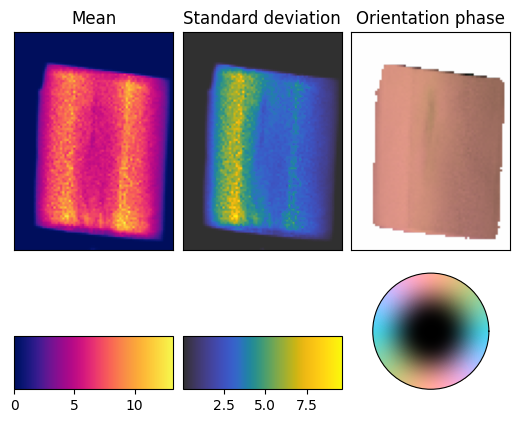

In [2]:
from mumott.output_handling import ProjectionViewer
p = ProjectionViewer(data_container, orientation_symmetry='transversal')


### 3 Reconstruction

In [4]:
from mumott.pipelines.reconstruction import run_group_lasso
from mumott.methods.basis_sets import GaussianKernels

# Test run to find a good value for the step size parameter
basis_set = GaussianKernels(grid_scale=4)

results = run_group_lasso(
    data_container,
    regularization_parameter=0,
    basis_set=basis_set,
    use_gpu=True,
    maxiter=1,
    enforce_non_negativity=True,
    no_tqdm=False,
)

step_size_parameter = results['optimizer']._step_size_parameter
print(step_size_parameter)

50
INFO:Calculating step size parameter.


Loss = 2.92E+08: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

0.0002351523886223905


In [9]:
from tqdm import tqdm
# Large loop over regularization parameters
regularization_parameter_list = np.logspace(1.5, 3.5, 9)

solution_norm_list = []
residual_norm_list = []
nonzero_fraction_list = []

for regularization_parameter in tqdm(regularization_parameter_list):
    
    results = run_group_lasso(data_container,
        regularization_parameter = regularization_parameter,
        basis_set = basis_set,
        use_gpu = True,
        maxiter = 30,
        enforce_non_negativity = True,
        no_tqdm = True,
        step_size_parameter = step_size_parameter,
    )

    solution_norm_list.append(np.sum(results['result']['x']**2))
    residual_norm_list.append(results['loss_function'].get_loss()['loss'])
    nonzero_fraction_list.append(np.mean(np.any(results['result']['x']!=0.0, axis=-1)))



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:57<00:00, 39.70s/it]


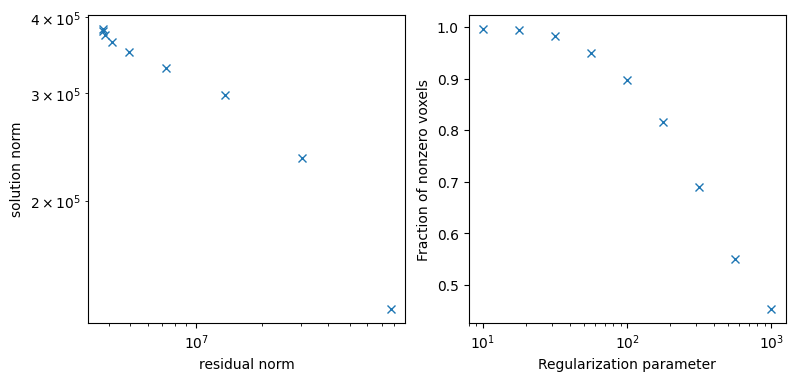

In [10]:
fig = plt.figure(figsize = (9,4))

plt.subplot(1,2,1)
plt.loglog(residual_norm_list, solution_norm_list, 'x')
plt.ylabel('solution norm')
plt.xlabel('residual norm')

plt.subplot(1,2,2)
plt.semilogx(regularization_parameter_list, nonzero_fraction_list, 'x')
plt.ylabel('Fraction of nonzero voxels')
plt.xlabel('Regularization parameter')
plt.show()


In [11]:

results = run_group_lasso(data_container,
    regularization_parameter = 1e3,
    basis_set = basis_set,
    use_gpu = True,
    maxiter = 100,
    enforce_non_negativity = True,
    no_tqdm = False,
    step_size_parameter = step_size_parameter,
)


Loss = 2.09E+08: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


### 4 Plots

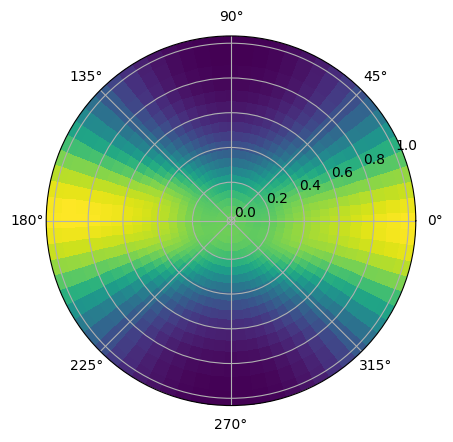

In [14]:
intens, theta, phi = basis_set.generate_map(results['result']['x'][15, 40, 30])

ax = plt.subplot(1,1,1,polar=True)
ax.pcolormesh(phi, np.tan(theta/2), intens)




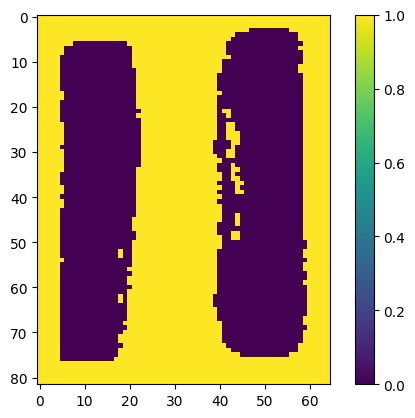

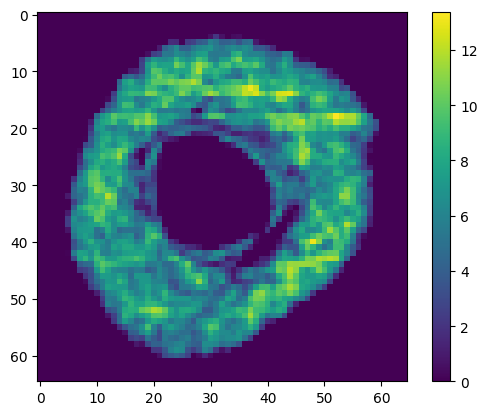

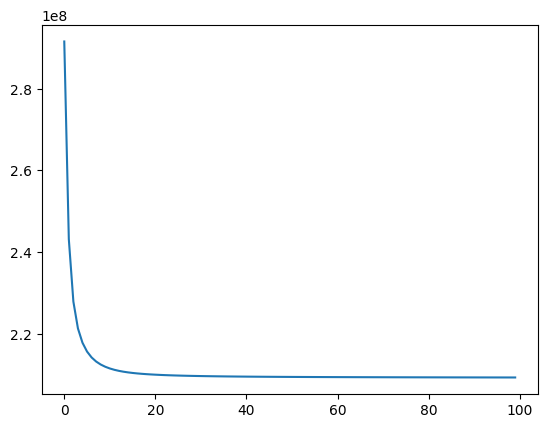

In [13]:
plt.imshow(np.sum(results['result']['x'][35, :, :, :], axis = -1)==0.0)
plt.colorbar()
plt.show()

plt.imshow(np.sum(results['result']['x'][:, 40, :, :], axis = -1))
plt.colorbar()
plt.show()

plt.plot(results['optimizer'].error_function_history)

### 5 Make a paraview file

In [15]:
# This is here temporarily, will be added to main mumott soon
import h5py
import numpy as np
import os
import h5py
from matplotlib.colors import hsv_to_rgb


def halfsphere_color(vectors):
    """ A mapping from unit-vectors with inversion symmetry
    to RGB-colors.
    """

    vectors = np.copy(vectors)
    whereflip = vectors[..., 1] < 0
    vectors[whereflip, :] = -vectors[whereflip, :]

    theta = np.arccos(vectors[..., 1])
    phi = np.arctan2(vectors[..., 2], vectors[..., 0])
    hue = ((phi) % (np.pi))/np.pi
    saturation = (np.arctan(theta/2) / np.arctan(np.pi/4))**2
    modifier = -np.sin(phi)*np.sin(2*theta)**2
    modifier = np.sign(modifier) * np.abs(modifier)
    value = np.ones(theta.shape)*0.7 + 0.2*modifier

    hsv = np.stack([hue, saturation, value], axis=-1)
    return hsv_to_rgb(hsv)



def save_to_disk(output, filename : str):

        if filename.endswith('.h5') or filename.lower().endswith('.xdmf'):

            filename, _ = os.path.splitext(filename)
            basename = os.path.basename(filename)

        else:
            raise InputError('Fileformat not supported.')    

    # Make .h5 data file
        with h5py.File(filename + '.h5', 'w') as file:

            file.create_dataset('mean_intensity', data=output.mean_intensity.transpose((2, 1, 0)))
            file.create_dataset('fractional_anisotropy', data=output.fractional_anisotropy.transpose((2, 1, 0)))

            file.create_dataset('eigenvector_1', data=output.eigenvector_1.transpose((2, 1, 0, 3)))
            file.create_dataset('eigenvector_2', data=output.eigenvector_2.transpose((2, 1, 0, 3)))
            file.create_dataset('eigenvector_3', data=output.eigenvector_3.transpose((2, 1, 0, 3)))

            file.create_dataset('eigenvector_1_rgb',
                                data=halfsphere_color(output.eigenvector_1).transpose((2, 1, 0, 3)))
            file.create_dataset('eigenvector_2_rgb',
                                data=halfsphere_color(output.eigenvector_2).transpose((2, 1, 0, 3)))
            file.create_dataset('eigenvector_3_rgb',
                                data=halfsphere_color(output.eigenvector_3).transpose((2, 1, 0, 3)))

            file.create_dataset('eigenvalue_1', data=output.eigenvalue_1.transpose((2, 1, 0)))
            file.create_dataset('eigenvalue_2', data=output.eigenvalue_2.transpose((2, 1, 0)))
            file.create_dataset('eigenvalue_3', data=output.eigenvalue_3.transpose((2, 1, 0)))

            file.create_dataset('second_moment_tensor',
                                data=output.second_moment_tensor.transpose((2, 1, 0, 3, 4)))

        # Make XDMF file for paraview
        with open(filename + '.xdmf', 'w') as file:

            # Header
            file.write('''<?xml version="1.0" ?>
    <!DOCTYPE Xdmf SYSTEM "Xdmf.dtd" []>
    <Xdmf Version="2.0">
    <Domain>
    <Grid Name="Structured Grid" GridType="Uniform">
    ''')
            file.write('<Topology TopologyType="3DCoRectMesh" NumberOfElements="' +
                       f'{output.volume_shape[2]} {output.volume_shape[1]} {output.volume_shape[0]}"/>\n')
            file.write('''   <Geometry GeometryType="Origin_DxDyDz">
    <DataItem Name="Origin" Dimensions="3" NumberType="Float" Precision="8" Format="XML">
        0 0 0
    </DataItem>
    <DataItem Name="Spacing" Dimensions="3" NumberType="Float" Precision="8" Format="XML">
            1.0 1.0 1.0
        </DataItem>
    </Geometry>
    
    ''')

            # Scalars
            for data_string in [
                    'mean_intensity',
                    'fractional_anisotropy',
                    'eigenvalue_1',
                    'eigenvalue_2',
                    'eigenvalue_3',]:
                file.write(f'<Attribute Name="{data_string}" AttributeType="Scalar" Center="Cell">\n')
                file.write('    <DataItem Dimensions="' +
                           f'{output.volume_shape[2]} {output.volume_shape[1]} {output.volume_shape[0]}"' +
                           ' NumberType="Float" Precision="8" Format="HDF">\n')
                file.write(f'        {basename}.h5:/{data_string}')
                file.write('''
        </DataItem>
    </Attribute>
    
    ''')

            # Vectors
            for data_string in [
                    'eigenvector_1',
                    'eigenvector_2',
                    'eigenvector_3',
                    'eigenvector_1_rgb',
                    'eigenvector_2_rgb',
                    'eigenvector_3_rgb',]:
                file.write(f'<Attribute Name="{data_string}" AttributeType="Vector" Center="Cell">\n')
                file.write('    <DataItem Dimensions="' +
                           f'{output.volume_shape[2]} {output.volume_shape[1]} {output.volume_shape[0]} 3"' +
                           ' NumberType="Float" Precision="8" Format="HDF">\n')
                file.write(f'        {basename}.h5:/{data_string}')
                file.write('''
        </DataItem>
    </Attribute>
    
    ''')

            file.write('''</Grid>
    </Domain>
    </Xdmf>
    ''')

        return 0


In [18]:
# Save output to fileformat that paraview can load in paraview geometric convention.
output = basis_set.get_output(results['result']['x'])
save_to_disk(output, 'frog_recon.xdmf')


0